# ExoNAMD API v1.0


## Summary

The observer wants to compute the relative and/or absolute NAMD of:

- a given multiplanetary system;
- a subset of multiplanetary systems;
- all the known ones.

This tool handles all of the above cases.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import swifter
import warnings
from loguru import logger

from exonamd.catalog import download_nasa_confirmed_planets
from exonamd.utils import ROOT
from exonamd.utils import fetch_aliases
from exonamd.utils import update_host
from exonamd.utils import update_planet
from exonamd.utils import check_name
from exonamd.solve import solve_values
from exonamd.interp import interp_eccentricity
from exonamd.interp import interp_mass
from exonamd.interp import interp_inclination
from exonamd.interp import interp_sma
from exonamd.solve import solve_relincl
from exonamd.interp import interp_trueobliq
from exonamd.utils import groupby_apply_merge
from exonamd.solve import solve_namd
from exonamd.solve import solve_namd_mc
from exonamd.plot import plot_host_namd
from exonamd.plot import pop_plot


warnings.filterwarnings("ignore")
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
swifter.set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=False,
)

/home/ariel/andrea.bocchieri/.local/lib/python3.10/site-packages/pytools/persistent_dict.py:59: UserWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


### Task 1: getting the data

This task retrieves the parameters of confirmed systems from the NASA Exoplanet Archive database.


In [3]:
df, df_old = download_nasa_confirmed_planets(
    min_sy_pnum=2,
    from_scratch=True,
)

2024-08-20 12:18:47.471 | INFO     | exonamd.catalog:download_nasa_confirmed_planets:17 - Downloading NASA Exoplanet Archive confirmed planets
2024-08-20 12:18:47.473 | DEBUG    | exonamd.catalog:download_nasa_confirmed_planets:28 - Defining the SQL query to retrieve the required data
2024-08-20 12:18:47.475 | DEBUG    | exonamd.catalog:download_nasa_confirmed_planets:65 - Making the request to the API


2024-08-20 12:19:14.715 | INFO     | exonamd.catalog:download_nasa_confirmed_planets:81 - Data fetched


### Task 2: dealing with the aliases


Fetch aliases


In [4]:
out_path = os.path.join(ROOT, "data", "aliases.pkl")
aliases = fetch_aliases(
    hosts=df["hostname"].unique(),
    output_file=out_path,
)

2024-08-20 12:19:14.788 | INFO     | exonamd.utils:fetch_aliases:311 - Fetching aliases for host stars and their planets


2024-08-20 12:22:14.678 | INFO     | exonamd.utils:fetch_nea_aliases:159 - Fetched 966/966 entries on try 1
2024-08-20 12:22:18.425 | INFO     | exonamd.utils:fetch_aliases:403 - Aliases fetched.
2024-08-20 12:22:18.427 | INFO     | exonamd.utils:fetch_aliases:406 - Saving aliases to pickle
2024-08-20 12:22:18.444 | INFO     | exonamd.utils:fetch_aliases:409 - Aliases saved to /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/aliases.pkl


Curate aliases


In [5]:
logger.info("Updating host and planet names")
df["hostname"] = df.swifter.apply(update_host, args=(aliases,), axis=1)
df["pl_name"] = df.swifter.apply(update_planet, args=(aliases,), axis=1)
logger.info("Names updated")

2024-08-20 12:22:18.864 | INFO     | __main__:<module>:1 - Updating host and planet names


Pandas Apply:   0%|          | 0/16966 [00:00<?, ?it/s]

2024-08-20 12:22:20.502 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet TOI-411 c to HD 22946 c
2024-08-20 12:22:20.531 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet KIC 8540376 b to KOI-7892 b
2024-08-20 12:22:20.539 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet Kepler-458 c to KIC 9663113 c
2024-08-20 12:22:20.586 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet TOI-411 c to HD 22946 c
2024-08-20 12:22:20.614 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet KIC 8540376 b to KOI-7892 b
2024-08-20 12:22:20.621 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet Kepler-458 c to KIC 9663113 c
2024-08-20 12:22:20.666 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet TOI-411 c to HD 22946 c
2024-08-20 12:22:20.694 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet KIC 8540376 b to KOI-7892 b
2024-08-20 12:22:20.702 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet K

Pandas Apply:   0%|          | 0/16966 [00:00<?, ?it/s]

2024-08-20 12:22:20.845 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet TOI-1338 b to TOI-1338 A b
2024-08-20 12:22:20.847 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet TOI-1338 b to TOI-1338 A b
2024-08-20 12:22:20.863 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet TOI-1338 b to TOI-1338 A b
2024-08-20 12:22:20.866 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet TOI-1338 c to TOI-1338 A c
2024-08-20 12:22:20.871 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet TOI-1338 b to TOI-1338 A b
2024-08-20 12:22:20.872 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet TOI-1338 c to TOI-1338 A c
2024-08-20 12:22:20.911 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet HIP 29442 c to HD 42813 c
2024-08-20 12:22:20.936 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet pi Men c to HD 39091 c
2024-08-20 12:22:20.937 | DEBUG    | exonamd.utils:update_planet:433 - Updating planet pi Men

Check consistency of planet names


In [6]:
logger.info("Checking consistency of planet names")
name_ok = df.groupby("hostname")["pl_name"].apply(check_name)

for hostname in name_ok[~name_ok].index:
    logger.error(f"Inconsistent planet names for {hostname}")
logger.info("Consistency check done")

2024-08-20 12:22:23.109 | INFO     | __main__:<module>:1 - Checking consistency of planet names
2024-08-20 12:22:23.131 | INFO     | __main__:<module>:6 - Consistency check done


### Task 3: computing missing values (if any) from simple relations


In [7]:
logger.info("Computing missing values from simple relations")
df[
    [
        "pl_orbsmax",
        "pl_ratdor",
        "st_rad",
        "pl_rade",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ]
] = df.swifter.apply(solve_values, axis=1)
logger.info("Missing values computed")

2024-08-20 12:22:23.746 | INFO     | __main__:<module>:1 - Computing missing values from simple relations


Pandas Apply:   0%|          | 0/16966 [00:00<?, ?it/s]

2024-08-20 12:22:35.775 | INFO     | __main__:<module>:13 - Missing values computed


### Task 4: storing the curated database


Drop columns that are no longer needed


In [8]:
logger.debug("Dropping columns that are no longer needed")
df.drop(
    columns=[
        "pl_ratdor",
        "st_rad",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ],
    inplace=True,
)
logger.debug("Columns dropped")

2024-08-20 12:22:36.263 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-08-20 12:22:36.266 | DEBUG    | __main__:<module>:12 - Columns dropped


In [9]:
logger.info("Storing the curated database")
if df_old is not None:
    df = pd.concat([df.copy(), df_old], ignore_index=True)
    df = df.drop_duplicates(keep="last")
    df.reset_index(drop=True)

out_path = os.path.join(ROOT, "data", "exo.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-08-20 12:22:36.994 | INFO     | __main__:<module>:1 - Storing the curated database


2024-08-20 12:22:37.107 | INFO     | __main__:<module>:9 - Database stored at /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/exo.csv


In [10]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo.csv"))

### Task 5: input missing values (if any) by interpolation


Use nanmedian to thin down the data


In [11]:
logger.info("Thinning down the data with nanmedian")
cols = df.columns.difference(["hostname", "pl_name", "default_flag", "rowupdate"])
medians = df.groupby("pl_name")[cols].transform(np.nanmedian)
df.loc[df["default_flag"] == 1, cols] = medians.loc[df["default_flag"] == 1]
df = df[df["default_flag"] == 1].drop(columns="default_flag")
logger.info("Data thinned down")

2024-08-20 12:22:37.425 | INFO     | __main__:<module>:1 - Thinning down the data with nanmedian
2024-08-20 12:22:37.454 | INFO     | __main__:<module>:6 - Data thinned down


Check presence of duplicates (if any)


In [12]:
logger.info("Checking for duplicates")
dp = df[df.duplicated(subset=["hostname", "pl_name"], keep=False)].sort_values(
    by=["hostname", "pl_name"]
)

if len(dp) > 0:
    logger.error(f"Duplicated rows for {dp['hostname'].unique()}")
    raise ValueError(f"Duplicated rows for {dp['hostname'].unique()}")
logger.info("No duplicates found")

2024-08-20 12:22:37.624 | INFO     | __main__:<module>:1 - Checking for duplicates
2024-08-20 12:22:37.629 | INFO     | __main__:<module>:9 - No duplicates found


Instantiate flags


In [13]:
logger.info("Instantiating the flags")
df["flag"] = "0"
logger.info("Flags instantiated")

2024-08-20 12:22:37.943 | INFO     | __main__:<module>:1 - Instantiating the flags
2024-08-20 12:22:37.946 | INFO     | __main__:<module>:3 - Flags instantiated


Solve missing eccentricity values


In [14]:
logger.info("Interpolating missing eccentricity values")
df[
    [
        "pl_orbeccen",
        "pl_orbeccenerr1",
        "pl_orbeccenerr2",
        "flag",
    ]
] = df.swifter.apply(interp_eccentricity, axis=1)
logger.info("Values interpolated")

2024-08-20 12:22:38.113 | INFO     | __main__:<module>:1 - Interpolating missing eccentricity values


Pandas Apply:   0%|          | 0/2418 [00:00<?, ?it/s]

2024-08-20 12:22:38.971 | INFO     | __main__:<module>:10 - Values interpolated


Solve missing planetary mass values


In [15]:
logger.info("Interpolating missing planetary mass values")
df[
    [
        "pl_bmasse",
        "pl_bmasseerr1",
        "pl_bmasseerr2",
        "flag",
    ]
] = df.swifter.apply(interp_mass, axis=1)
logger.info("Values interpolated")

2024-08-20 12:22:39.233 | INFO     | __main__:<module>:1 - Interpolating missing planetary mass values


Pandas Apply:   0%|          | 0/2418 [00:00<?, ?it/s]

2024-08-20 12:24:56.348 | INFO     | __main__:<module>:10 - Values interpolated


Drop columns that are no longer needed


In [16]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"], inplace=True)
logger.debug("Columns dropped")

2024-08-20 12:24:56.876 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-08-20 12:24:56.880 | DEBUG    | __main__:<module>:3 - Columns dropped


Remove systems where at least one planet has no mass or semi-major axis (if any)


In [17]:
logger.info("Removing systems where at least one planet has no mass or semi-major axis")
mask = (
    df.groupby("hostname")[["pl_bmasse", "pl_orbsmax"]]
    .transform(lambda x: x.isnull().any())
    .any(axis=1)
)
rm_systems = df[mask]["hostname"].unique()
logger.info(f"Removing {len(rm_systems)} systems: {rm_systems}")
df = df[~mask]
logger.info("Systems removed")

2024-08-20 12:24:57.091 | INFO     | __main__:<module>:1 - Removing systems where at least one planet has no mass or semi-major axis


2024-08-20 12:24:57.449 | INFO     | __main__:<module>:8 - Removing 23 systems: ['Kepler-397' 'HIP 41378' 'TOI-1634' 'Kepler-444' 'HD 41004 A'
 'Kepler-511' 'Kepler-1085' 'Kepler-297' 'Kepler-487' 'Kepler-799'
 'Kepler-1311' 'Kepler-603' 'KIC 5437945' 'Kepler-730' 'LkCa 15'
 'Kepler-141' 'KIC 10001893' 'Kepler-118' 'Kepler-561' 'Kepler-302'
 'Kepler-230' 'Kepler-108' 'Kepler-148']
2024-08-20 12:24:57.452 | INFO     | __main__:<module>:10 - Systems removed


Solve missing values in inclinations


In [18]:
logger.info("Interpolating missing values in inclinations")
df[
    [
        "pl_orbincl",
        "pl_orbinclerr1",
        "pl_orbinclerr2",
        "flag",
    ]
] = df.swifter.apply(interp_inclination, args=(df,), axis=1)
logger.info("Values interpolated")

2024-08-20 12:24:57.790 | INFO     | __main__:<module>:1 - Interpolating missing values in inclinations


Pandas Apply:   0%|          | 0/2361 [00:00<?, ?it/s]

2024-08-20 12:25:02.241 | INFO     | __main__:<module>:10 - Values interpolated


Interpolate missing values in semi-major axis uncertainties


In [19]:
logger.info("Interpolating missing values in semi-major axis uncertainties")
df[
    [
        "pl_orbsmaxerr1",
        "pl_orbsmaxerr2",
        "flag",
    ]
] = df.swifter.apply(interp_sma, axis=1)
logger.info("Values interpolated")

2024-08-20 12:25:02.503 | INFO     | __main__:<module>:1 - Interpolating missing values in semi-major axis uncertainties


Pandas Apply:   0%|          | 0/2361 [00:00<?, ?it/s]

2024-08-20 12:25:03.316 | INFO     | __main__:<module>:9 - Values interpolated


### Task 6: compute the parameters for the NAMD calculation


Compute the relative inclination


In [20]:
logger.info("Computing the relative inclinations")
df[
    [
        "pl_relincl",
        "pl_relinclerr1",
        "pl_relinclerr2",
    ]
] = df.swifter.apply(solve_relincl, args=(df,), axis=1)
logger.info("Values computed")

2024-08-20 12:25:03.759 | INFO     | __main__:<module>:1 - Computing the relative inclinations


Pandas Apply:   0%|          | 0/2361 [00:00<?, ?it/s]

2024-08-20 12:25:07.899 | INFO     | __main__:<module>:9 - Values computed


Interpolate missing values in true obliquity


In [21]:
logger.info("Interpolating missing values in true obliquity")
df[
    [
        "pl_trueobliq",
        "pl_trueobliqerr1",
        "pl_trueobliqerr2",
        "flag",
    ]
] = df.swifter.apply(interp_trueobliq, args=(df,), axis=1)
logger.info("Values interpolated")

2024-08-20 12:25:08.112 | INFO     | __main__:<module>:1 - Interpolating missing values in true obliquity


Pandas Apply:   0%|          | 0/2361 [00:00<?, ?it/s]

2024-08-20 12:25:11.929 | INFO     | __main__:<module>:10 - Values interpolated


### Task 7: storing the curated+interpolated database


In [22]:
logger.info("Storing the curated+interpolated database")
out_path = os.path.join(ROOT, "data", "exo_interp.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-08-20 12:25:12.075 | INFO     | __main__:<module>:1 - Storing the curated+interpolated database
2024-08-20 12:25:12.108 | INFO     | __main__:<module>:4 - Database stored at /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/exo_interp.csv


In [23]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo_interp.csv"))

### Task 8: computing the NAMD


Drop columns that are no longer needed

In [24]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_orbincl", "pl_orbinclerr1", "pl_orbinclerr2"], inplace=True)
logger.debug("Columns dropped")

2024-08-20 12:25:12.539 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2024-08-20 12:25:12.541 | DEBUG    | __main__:<module>:3 - Columns dropped


Solve the relative and absolute namd


In [25]:
logger.info("Computing the relative NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="rel",
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2024-08-20 12:25:12.756 | INFO     | __main__:<module>:1 - Computing the relative NAMD


2024-08-20 12:25:14.627 | INFO     | __main__:<module>:9 - Relative NAMD computed


In [26]:
logger.info("Computing the absolute NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="abs",
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2024-08-20 12:25:14.800 | INFO     | __main__:<module>:1 - Computing the absolute NAMD


2024-08-20 12:25:16.703 | INFO     | __main__:<module>:9 - Absolute NAMD computed


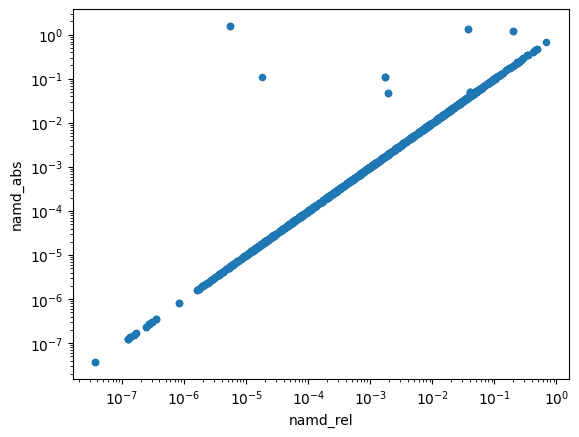

In [27]:
_ = (
    df.groupby("hostname")[["namd_rel", "namd_abs"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel", y="namd_abs", loglog=True)
)

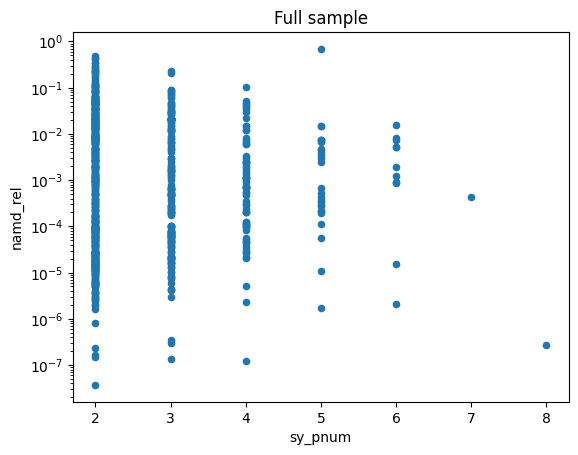

In [28]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_rel"]]
    .mean()
    .reset_index()
    .plot(kind="scatter", x="sy_pnum", y="namd_rel", logy=True, title="Full sample")
)

Core sample


In [29]:
core = True

In [30]:
if core:
    logger.info("Defining the core sample")
    core_flags = ["0", "05+", "05-", "05+-"]
    df = df.groupby("hostname").filter(lambda x: all(x["flag"].isin(core_flags)))
    logger.info("Core sample defined")

2024-08-20 12:25:20.218 | INFO     | __main__:<module>:2 - Defining the core sample


2024-08-20 12:25:20.413 | INFO     | __main__:<module>:5 - Core sample defined


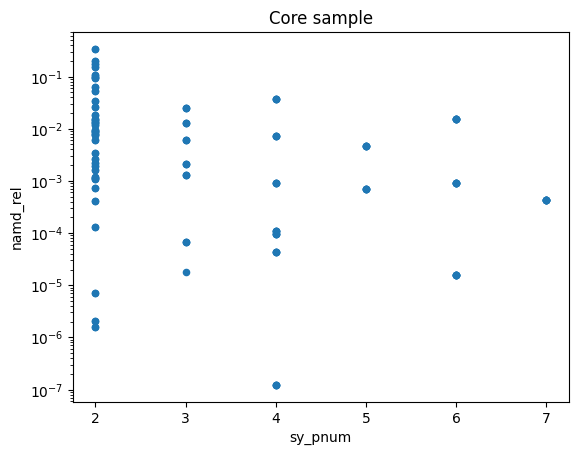

In [31]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_rel"]]
    .transform("mean")
    .plot(kind="scatter", x="sy_pnum", y="namd_rel", logy=True, title="Core sample")
)

### Task 9: computing the NAMD and associated confidence intervals


In [32]:
Npt = 200000
threshold = 100

In [33]:
logger.info("Computing the Monte Carlo relative NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd_mc,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2024-08-20 12:25:21.992 | INFO     | __main__:<module>:1 - Computing the Monte Carlo relative NAMD


2024-08-20 12:25:29.117 | INFO     | __main__:<module>:11 - Relative NAMD computed


In [34]:
logger.info("Computing the Monte Carlo absolute NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd_mc,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2024-08-20 12:25:29.304 | INFO     | __main__:<module>:1 - Computing the Monte Carlo absolute NAMD


2024-08-20 12:25:36.369 | INFO     | __main__:<module>:11 - Absolute NAMD computed


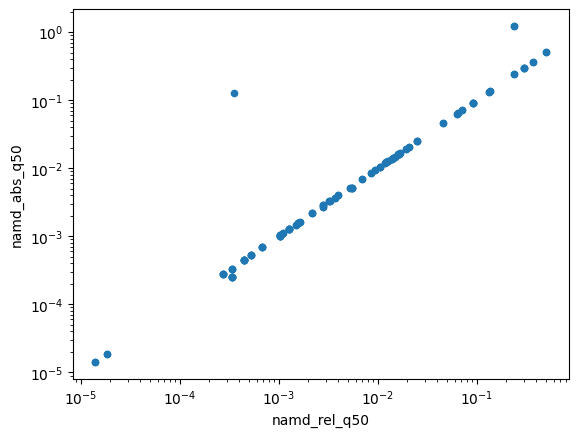

In [35]:
_ = (
    df.groupby("hostname")[["namd_rel_q50", "namd_abs_q50"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel_q50", y="namd_abs_q50", loglog=True)
)

In [36]:
logger.info("Storing the NAMD database")
out_path = os.path.join(ROOT, "data", "exo_namd.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2024-08-20 12:25:37.554 | INFO     | __main__:<module>:1 - Storing the NAMD database
2024-08-20 12:25:37.563 | INFO     | __main__:<module>:4 - Database stored at /export/NAS/ariel/users/andrea.bocchieri/.local/lib/python3.10/site-packages/exonamd/data/exo_namd.csv


In [37]:
df = pd.read_csv(os.path.join(ROOT, "data", "exo_namd.csv"))

### Some plots


2024-08-20 12:25:38.070 | INFO     | __main__:<module>:1 - Plotting the NAMD vs. multiplicity


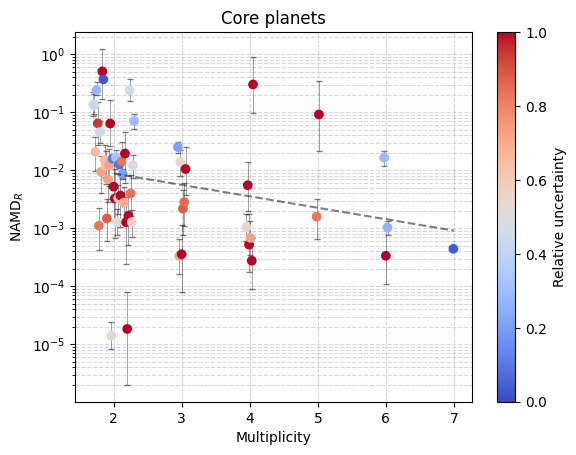

2024-08-20 12:25:38.579 | INFO     | __main__:<module>:12 - Plot done


In [ ]:
logger.info("Plotting the NAMD vs. multiplicity")
pop_plot(
    df=df.groupby("hostname").apply(
        lambda g: g.select_dtypes(exclude=["object"]).mean(),
    ),
    kind="rel",
    title="Core planets",
    which="namd",
    yscale="log",
)
logger.info("Plot done")

In [ ]:
Npt = 10000000
threshold = 1000

2024-10-13 15:45:40.467 | INFO     | exonamd.run:plot_host_namd:519 - Selecting the host: Kepler-462
2024-10-13 15:45:40.470 | INFO     | exonamd.run:plot_host_namd:521 - Host selected
2024-10-13 15:45:40.471 | INFO     | exonamd.run:plot_host_namd:523 - Computing the Monte Carlo relative NAMD


2024-10-13 15:45:45.051 | INFO     | exonamd.run:plot_host_namd:531 - Values computed
2024-10-13 15:45:45.056 | INFO     | exonamd.run:plot_host_namd:533 - Plotting the relative NAMD distribution


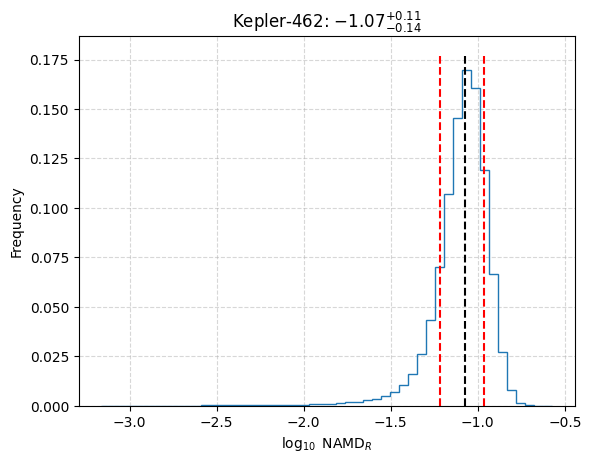

2024-10-13 15:45:45.395 | INFO     | exonamd.run:plot_host_namd:541 - Plot done


In [ ]:
plot_host_namd(
    df=df,
    hostname="XO-2 N",
    kind="rel",
    Npt=Npt,
    threshold=threshold,
)

2024-10-13 15:45:45.888 | INFO     | exonamd.run:plot_host_namd:519 - Selecting the host: Kepler-462
2024-10-13 15:45:45.891 | INFO     | exonamd.run:plot_host_namd:521 - Host selected
2024-10-13 15:45:45.892 | INFO     | exonamd.run:plot_host_namd:523 - Computing the Monte Carlo relative NAMD


2024-10-13 15:45:49.642 | INFO     | exonamd.run:plot_host_namd:531 - Values computed
2024-10-13 15:45:49.645 | INFO     | exonamd.run:plot_host_namd:533 - Plotting the relative NAMD distribution


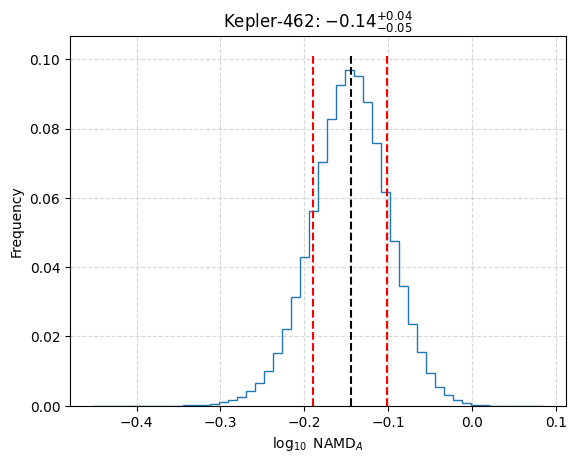

2024-10-13 15:45:50.161 | INFO     | exonamd.run:plot_host_namd:541 - Plot done


In [ ]:
plot_host_namd(
    df=df,
    hostname="XO-2 N",
    kind="abs",
    Npt=Npt,
    threshold=threshold,
)

TODO: 

1. check systems where the sy_pnum is different from the number of planets in the system reported in the exoplanet archive. e.g. XO-2 N
2. check compatibility with TepCat